In [75]:
# Libraries required for Neural Network
import numpy as np
import matplotlib.pyplot as plt
import time 
import copy
import torch
import torch.optim as optim
from torch.autograd import grad
from torch.autograd import Variable
import torch.nn as nn
dtype = torch.float

%matplotlib inline

In [76]:
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())

0
1
NVIDIA GeForce MX230
True


In [77]:
#device = 'cpu'
device = 'cuda:0'
# For plots
plt.rcParams.update({'font.size':16})

### Define general functions

In [78]:
# Define the sin() activation function
class mySin(torch.nn.Module):
    @staticmethod
    def forward(input):
        return torch.sin(input)

In [79]:
# Calculate the derivative with auto-differention
def df_dx(x,f):
    pts = torch.ones(x.shape, dtype=dtype, device=torch.device(device))
    return grad([f],[x],grad_outputs=pts,create_graph=True)[0]

In [80]:
# Stochastic perturbation of the evaluation points
# force t[0]=t0 & force points to be in the t-interval
def perturbation(grid,t0,tf,sig=0.5):
    delta_t = grid[1] - grid[0]
    noise = delta_t * torch.randn_like(grid) * sig
    t = grid + noise
    t.data[2] = torch.ones(1,1)*(-1)
    t.data[t<t0] = t0 - t.data[t<t0]
    t.data[t>tf] = 2*tf - t.data[t>tf]
    t.data[0] = torch.ones(1,1)*t0
    t.data[-1] = torch.ones(1,1)*tf
    t.requires_grad = False
    return t

In [81]:
# Trial or parametric solution for boundary contitions 
def parametric_solution(t,nn,t0,tf):
    N1,N2 = nn(t)
    # There are two parametric solutions, we take some that satisfy dirichlet conditions of radial part of hydrogen atom
    #g = (1-torch.exp(-t))*(1-torch.exp(t-tf))
    g = 1-torch.exp(t-tf)
    R_hat = g*N1
    return R_hat, N2

In [82]:
# Radial differential equation or eigenvalue problem of hamiltonian operator
def hamiltonian_equation(r,R,E,V):
    dR_dr = df_dx(r,R)
    dR_drr = df_dx(r,dR_dr)
    f = dR_drr + dR_dr*2/r + (E+V)*R
    L = (f.pow(2)).mean()
    var_loss = (f.pow(2)).var()    # variance of f
    H_R = -1*dR_drr - dR_dr*2/r - V*R
    return L, f, H_R, var_loss 

In [83]:
# Gives the potential at each point r
def potential(r,l):
    #l = 0
    rnp = r.data.numpy()    # points from tensor to numpy
    Vnp = -1*(-1/rnp + rnp) - l*(l+1)/rnp**2     # potential over numpy arrays
    Vtorch = torch.from_numpy(Vnp) 
    return Vtorch

### Define Neural Network model

In [84]:
class qNN(torch.nn.Module):
    def __init__(self, n_hl=10):      # neurons in hidden layer
        super(qNN,self).__init__()

        # Define the activation function
        self.activ_func = mySin()
        # Define layers
        self.E_in = torch.nn.Linear(1,1)
        self.Lin_1 = torch.nn.Linear(2,n_hl)
        self.Lin_2 = torch.nn.Linear(n_hl,n_hl)
        self.Lin_3 = torch.nn.Linear(n_hl,n_hl)
        self.out = torch.nn.Linear(n_hl,1)

    def forward(self,t):
            
        In_1 = self.E_in(torch.ones_like(t))
        L1 = self.Lin_1(torch.cat((t,In_1),1))
        h1 = self.activ_func(L1)
        L2 = self.Lin_2(h1)
        h2 = self.activ_func(L2)
        L3 = self.Lin_3(h2)
        h3 = self.activ_func(L3)
        out = self.out(h3)

        return out, torch.abs(In_1)   # Negative energy because eigenvalues are negatives for hydrogen atom

In [85]:
def weights_init(model,gain):
  for m in model.modules():
    if isinstance(m, nn.Linear):
      torch.nn.init.xavier_uniform_(m.weight.data, gain=gain)

### Training of Neural Network model

In [86]:
def training(t0, tf, neurons, epochs, n_train, lr, minibatch_number=1, models=[], l=0, gain=1, nlr=1.0, olr=1e-5):
    '''        
        Inputs
        t0 -- left point on domain
        tf -- right point on domain
        x1 -- 
        neurons -- number of units at hidden layer
        epochs -- number of iterations of training
        n_train -- number of points between t0 & tf including them
        lr -- learning rate 
        minibatch_number -- size of minibatch for points on domain
        orthtime -- time for training one eigenstate

        Outputs 
        model_1 -- best model for schrodinger equation (lowest loss)
        loss_histories -- tuple of lists with histories of variables
        runTime -- time of training
        fc_ground -- model for ground state 
        fc_first_excited -- model for first excited state
        model_0 -- last trained model 
    '''
    
    par2 = 0
    model = qNN(neurons)
    model = model.to(device)
    weights_init(model, gain)
    #model.apply(weights_init)
    model_aux = 0
    betas = [0.999,0.9999]
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=betas)

    # List's to save variables
    Loss_history = []         ;         Llim = 1e+20    # Upper limit of loss
    nontriv_loss_history = []
    SE_loss_history = []
    En_history = []
    orth_losses = []


    di = (None, 1e+20)
    dic = {}
    for i in range(1000):
        dic[i] = di

    grid = torch.linspace(t0,tf,n_train).reshape(-1,1)

    # Training iterations
    TeP0 = time.time()

    for tt in range(epochs+1):
        
        t = torch.abs(perturbation(grid,t0,tf,sig=0.03*tf)) + 1e-1
        norm_loss_reg = nlr   # regularization coefficient for normalization loss
        orth_loss_reg = olr    # regularization coefficient for orthogonality loss

        # Batching
        batch_size = int(n_train/minibatch_number)
        batch_start, batch_end = 0, batch_size

        idx = np.random.permutation(n_train)
        t_b = t[idx]
        t_b.requires_grad = True
        t_f = t[-1]
        t_f = t_f.reshape(-1,1)
        t_f.requires_grad = True
        loss = 0
            

        for nbatch in range(minibatch_number):
            # Batch time set
            t_mb = t_b[batch_start:batch_end].to(device)
            

            # Neural Network solutions
            nn, En = model(t_mb)
            Enp = En[0].data.tolist()[0]
            En_history.append(Enp)  # Append energy values from tensor to scalar (not list)

            psi = parametric_solution(t_mb, model, t0, tf)[0].to(device)
            Pot = potential(t_mb.to('cpu'),l)
            Ltot, f_red, H_psi, var_loss = hamiltonian_equation(t_mb, psi, En.to(device), Pot.to(device))
            Ltot *= 1
            SE_loss_history.append(Ltot.data.cpu().numpy())
            criteria_loss = Ltot

            # Normalization loss
            norm_loss = norm_loss_reg*(n_train/(tf-t0)*1.0 - torch.sqrt(torch.dot(psi[:,0],psi[:,0]))).pow(2)
            Ltot += norm_loss

            # Keep the log
            nontriv_loss_history.append(norm_loss.data.cpu().numpy())

            # Ortholoss after orthtime
            par = 0
            if len(models) == 0:
                orth_losses.append(None) 
            else:
                for mod in models: 
                    par += parametric_solution(t_mb, mod.to(device), t0, tf)[0]
                ortho_loss = orth_loss_reg*torch.sqrt(torch.dot(par[:,0]*t_mb[:,0], psi[:,0]*t_mb[:,0]).pow(2))
                orth_losses.append(ortho_loss.data.cpu().numpy())
                Ltot += ortho_loss            
            

            # Optimizer
            Ltot.backward(retain_graph=False)
            optimizer.step()
            loss += Ltot.to('cpu').data.numpy()
            optimizer.zero_grad()

            batch_start += batch_size
            batch_end += batch_size

        # Keep the loss function history
        Loss_history.append(loss)

        # Keep the best model (lowest loss) by using a deep copy
        if criteria_loss < Llim:
            model_aux = copy.deepcopy(model)
            Llim = criteria_loss
    
        
        E_bin = abs(En[0].data.tolist()[0]//0.01)
        if criteria_loss < dic[E_bin][1]:
            dic[E_bin] = (copy.deepcopy(model), criteria_loss, (t_mb, f_red, H_psi, psi))
        
        # Print learning progress
        if tt % 250 == 0:
          print('\rEpoch {}/{} ====================> - loss: {:.6f} - energy: {:.6f}'.format(tt,epochs,loss,Enp),end='')

    print('\n')
    TePf = time.time()
    runTime = TePf - TeP0
    loss_histories = (Loss_history, nontriv_loss_history, SE_loss_history, En_history, dic, orth_losses,l)
    return model, model_aux, loss_histories, runTime

In [87]:
def plots(t0, tf, n_train, model, history, save=''):
    # Test the predicted solution
    nTest = n_train
    tTest = torch.linspace(t0-0.1,tf+0.1,nTest).reshape(-1,1)
    tTest.requires_grad = True
    t_net = tTest.detach().numpy()
    psi,E = parametric_solution(tTest, model.to('cpu'), t0, tf)
    psi_net = psi.data.numpy()
    print(E.unique())

    # Loss funtion
    fig, axs = plt.subplots(2,2,figsize=(20,10))

    axs[0,0].set_title('Total loss')
    axs[0,0].plot(history[0], '-b', label='Total loss', alpha=0.8)
    axs[0,0].set_yscale('log')
    axs[0,0].set_xlabel('Epochs')
    axs[0,0].set_ylabel('Loss')
    axs[0,0].grid()
    axs[0,0].legend()

    axs[0,1].set_title('Contributions to loss')
    axs[0,1].plot(history[1], '-y', label='Norm loss', alpha=0.8)
    axs[0,1].plot(history[2], '.r', label='SE loss', alpha=0.8)
    axs[0,1].plot(history[5], '-g', label='Orth loss', alpha=0.8)
    axs[0,1].set_yscale('log')
    axs[0,1].set_xlabel('Epochs')
    axs[0,1].set_ylabel('Loss')
    axs[0,1].grid()
    axs[0,1].legend()

    axs[1,0].set_title('Eigenvalue')
    axs[1,0].plot(history[3], '-b', alpha=0.8, label='Eigenvalues')
    axs[1,0].set_yscale('log')
    axs[1,0].set_xlabel('Epochs')
    axs[1,0].set_ylabel('Energy history')
    axs[1,0].grid()
    axs[1,0].legend()

    axs[1,1].set_title('Radial wavefunction')
    axs[1,1].plot(t_net, psi_net, '-b', linewidth=1, alpha=0.8, label='Eigenfunction')
    axs[1,1].set_yscale('log')
    axs[1,1].set_xlabel('r')
    axs[1,1].set_ylabel('$\psi(r)$')
    axs[1,1].grid()
    axs[1,1].legend()

    plt.legend()
    plt.tight_layout()
    if save != '':
        plt.savefig(save,dpi=600)
    plt.show()

In [88]:
# Training the model
t0 = 0.1
tf = 10

n_train, neurons, epochs, lr= 1000, 100, int(5e1), 4e-3
model, best_model, loss_history, runTime1 = training(t0,tf,neurons,epochs,n_train,lr)
print('Training time (minutes): ',runTime1/60)    

Epoch 0/50 ====================> - loss: 6644.119629 - energy: 1.500493

Training time (minutes):  0.011952356497446696


tensor([1.6602], grad_fn=<Unique2Backward0>)


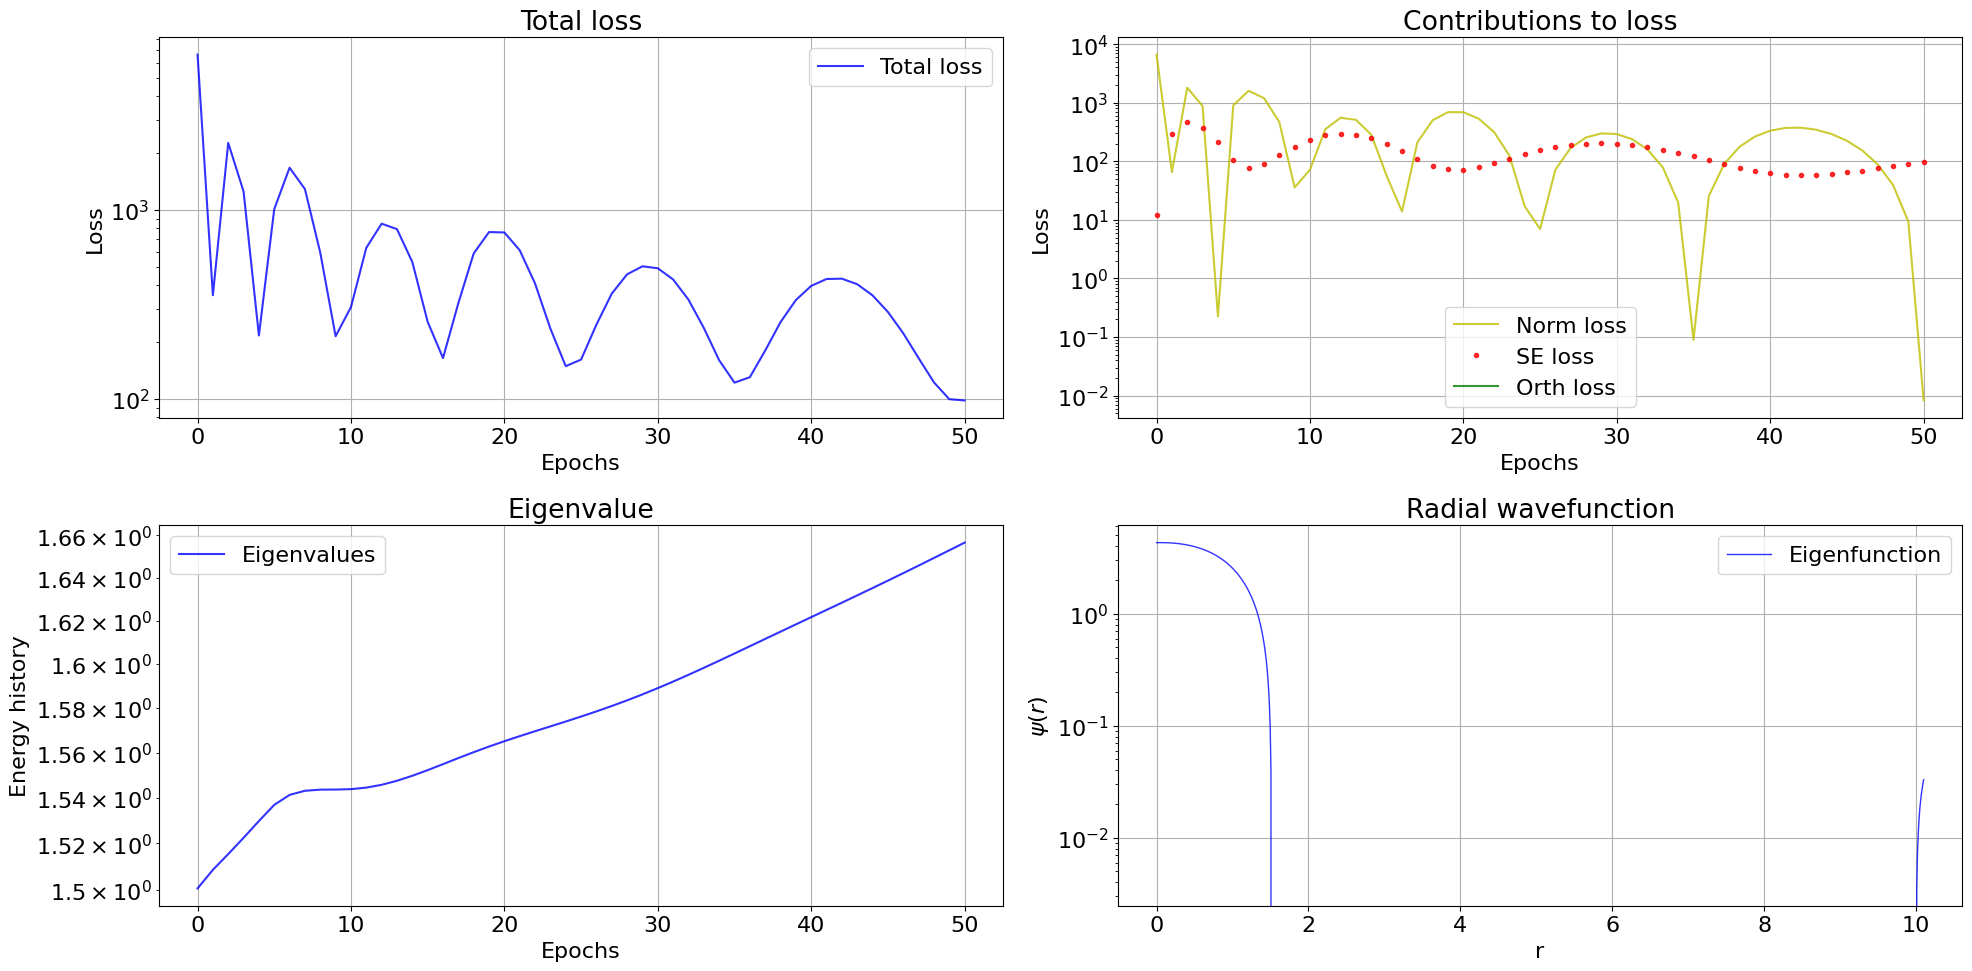

In [89]:
plots(t0,tf,n_train,model,loss_history)

tensor([1.6602], grad_fn=<Unique2Backward0>)


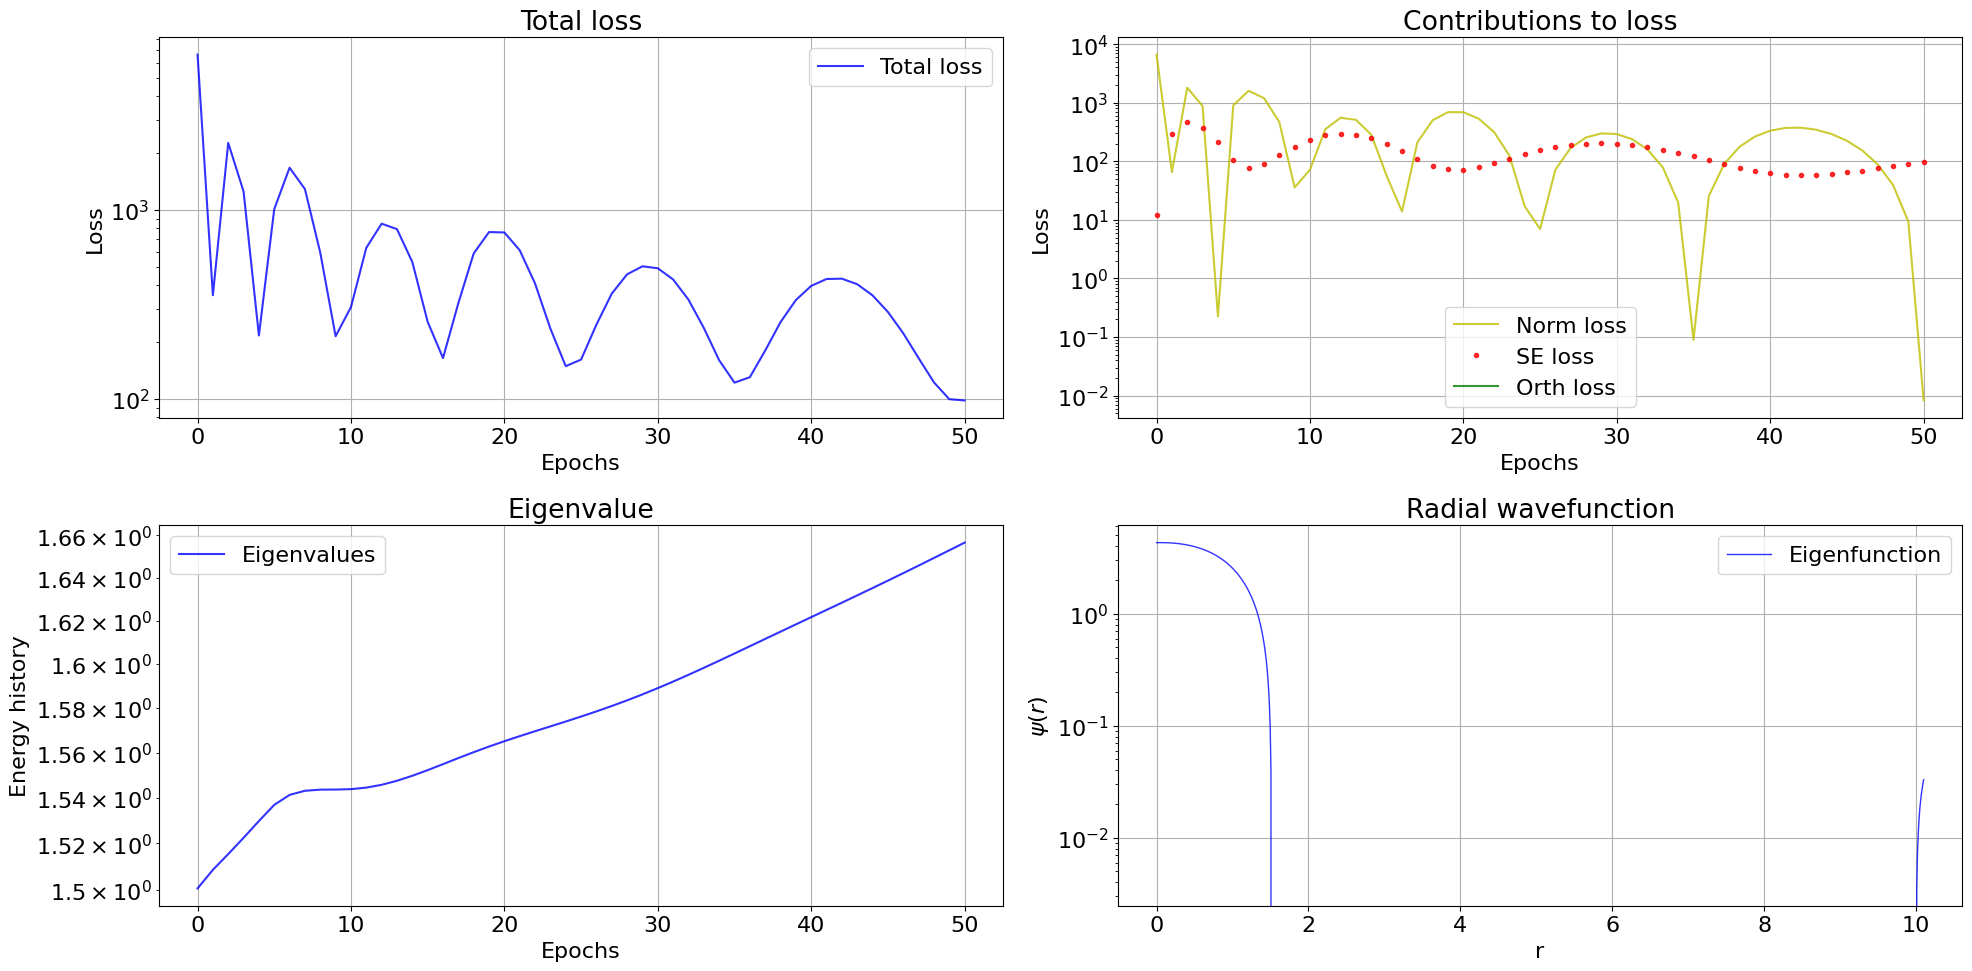

In [90]:
plots(t0,tf,n_train,best_model,loss_history)

In [91]:
# Training the model
t0 = 0.1
tf = 10

n_train, neurons, epochs, lr, gain, olr = 1000, 100, int(5e1), 4e-3, 2, 1e-3
model_f, best_model_f, loss_history_f, runTime1 = training(t0,tf,neurons,epochs,n_train,lr,models=[model],gain=gain,olr=olr)
print('Training time (minutes): ',runTime1/60)    

Epoch 0/50 ====================> - loss: 1480.445190 - energy: 2.494859

Training time (minutes):  0.01462615728378296


tensor([2.4411], grad_fn=<Unique2Backward0>)


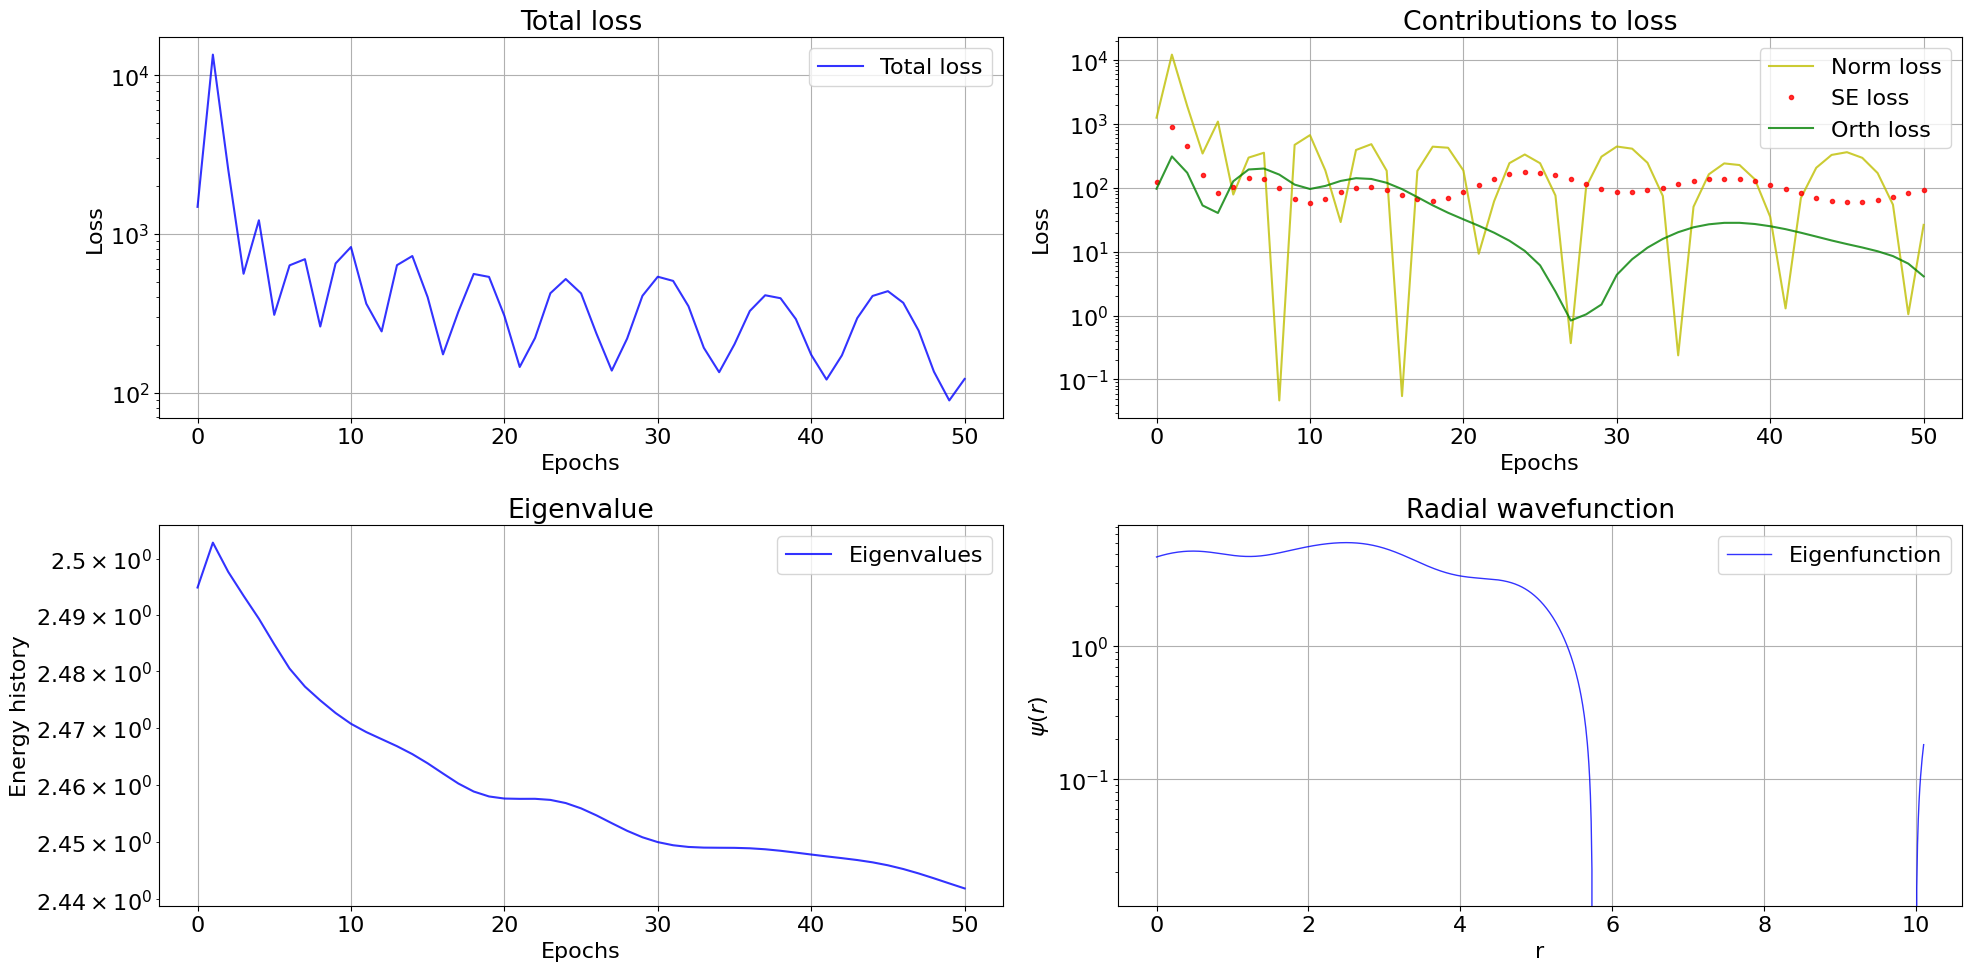

In [92]:
plots(t0,tf,n_train,model_f,loss_history_f)

tensor([2.4419], grad_fn=<Unique2Backward0>)


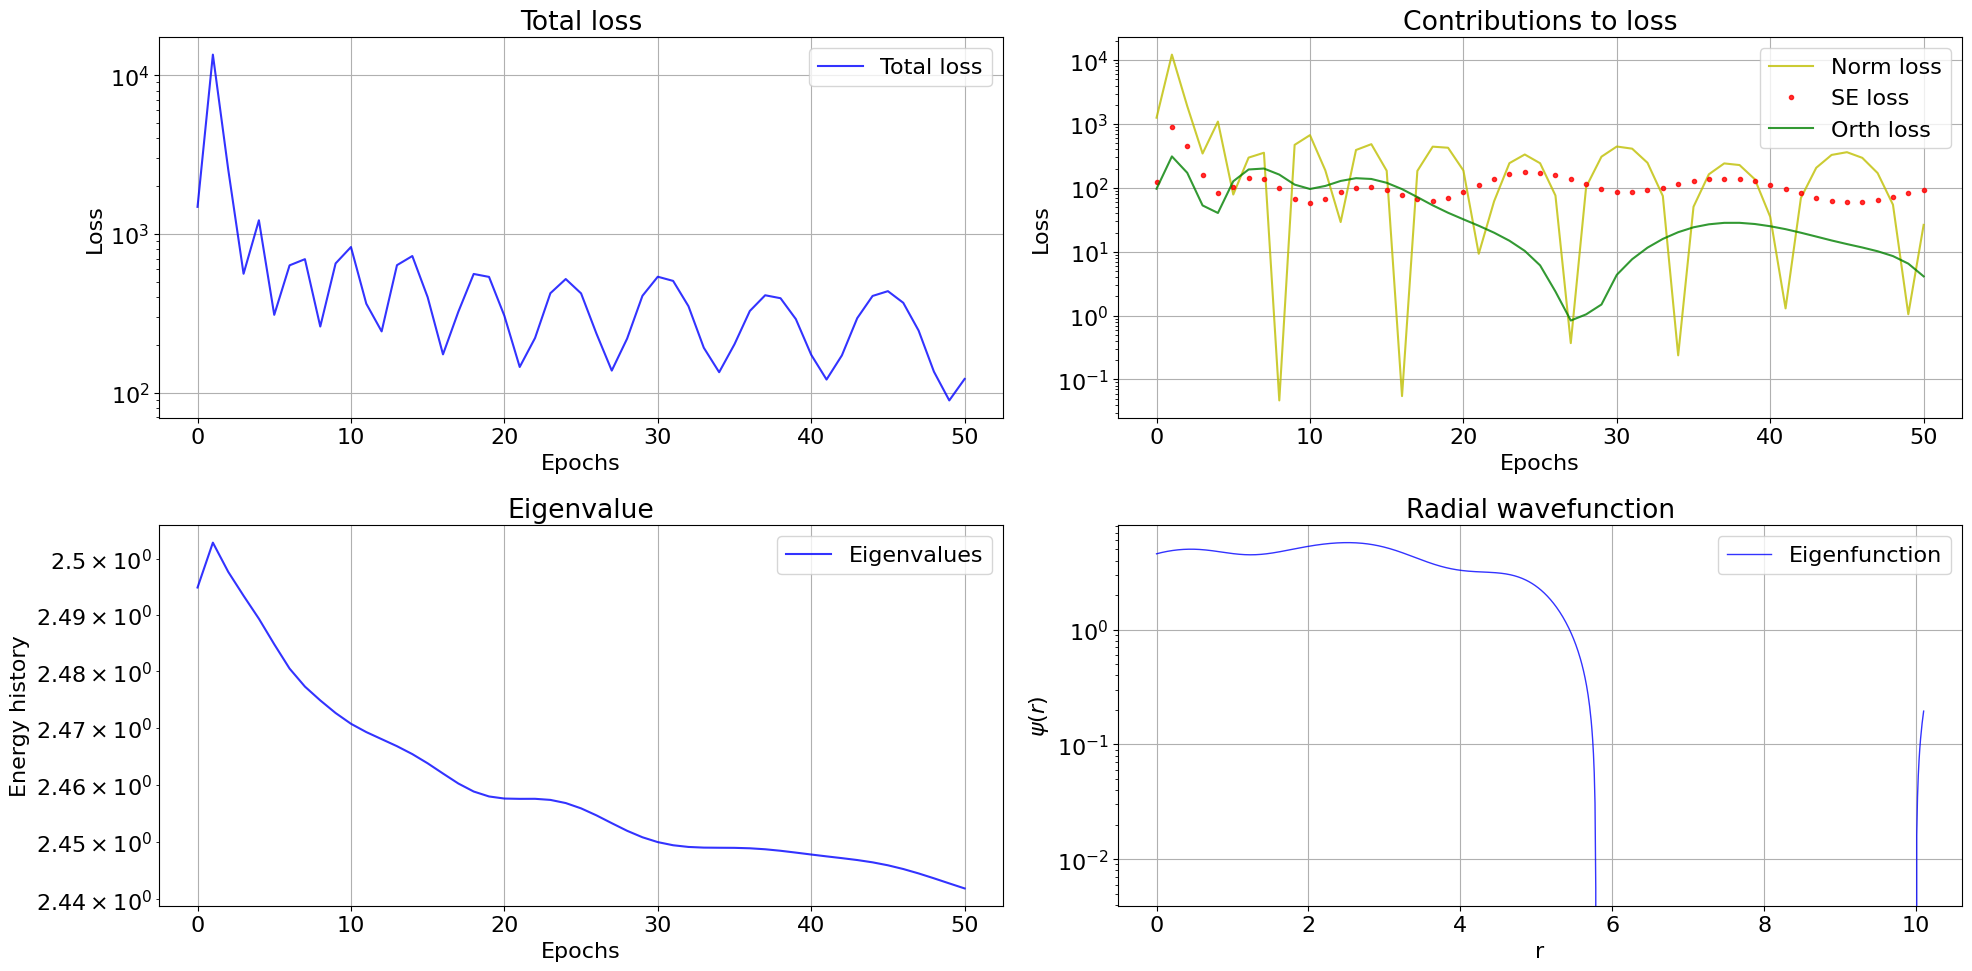

In [93]:
plots(t0,tf,n_train,best_model_f,loss_history_f)

In [94]:
# Training the model
t0 = 0.1
tf = 10

n_train, neurons, epochs, lr, gain, olr = 1000, 100, int(5e1), 2e-3, 5.2, 1e-4
model_s, best_model_s, loss_history_s, runTime1 = training(t0,tf,neurons,epochs,n_train,lr,models=[model,model_f],gain=gain,olr=olr)
print('Training time (minutes): ',runTime1/60)    

Epoch 0/50 ====================> - loss: 809135.625000 - energy: 5.603205

Training time (minutes):  0.016605953375498455


tensor([5.6030], grad_fn=<Unique2Backward0>)


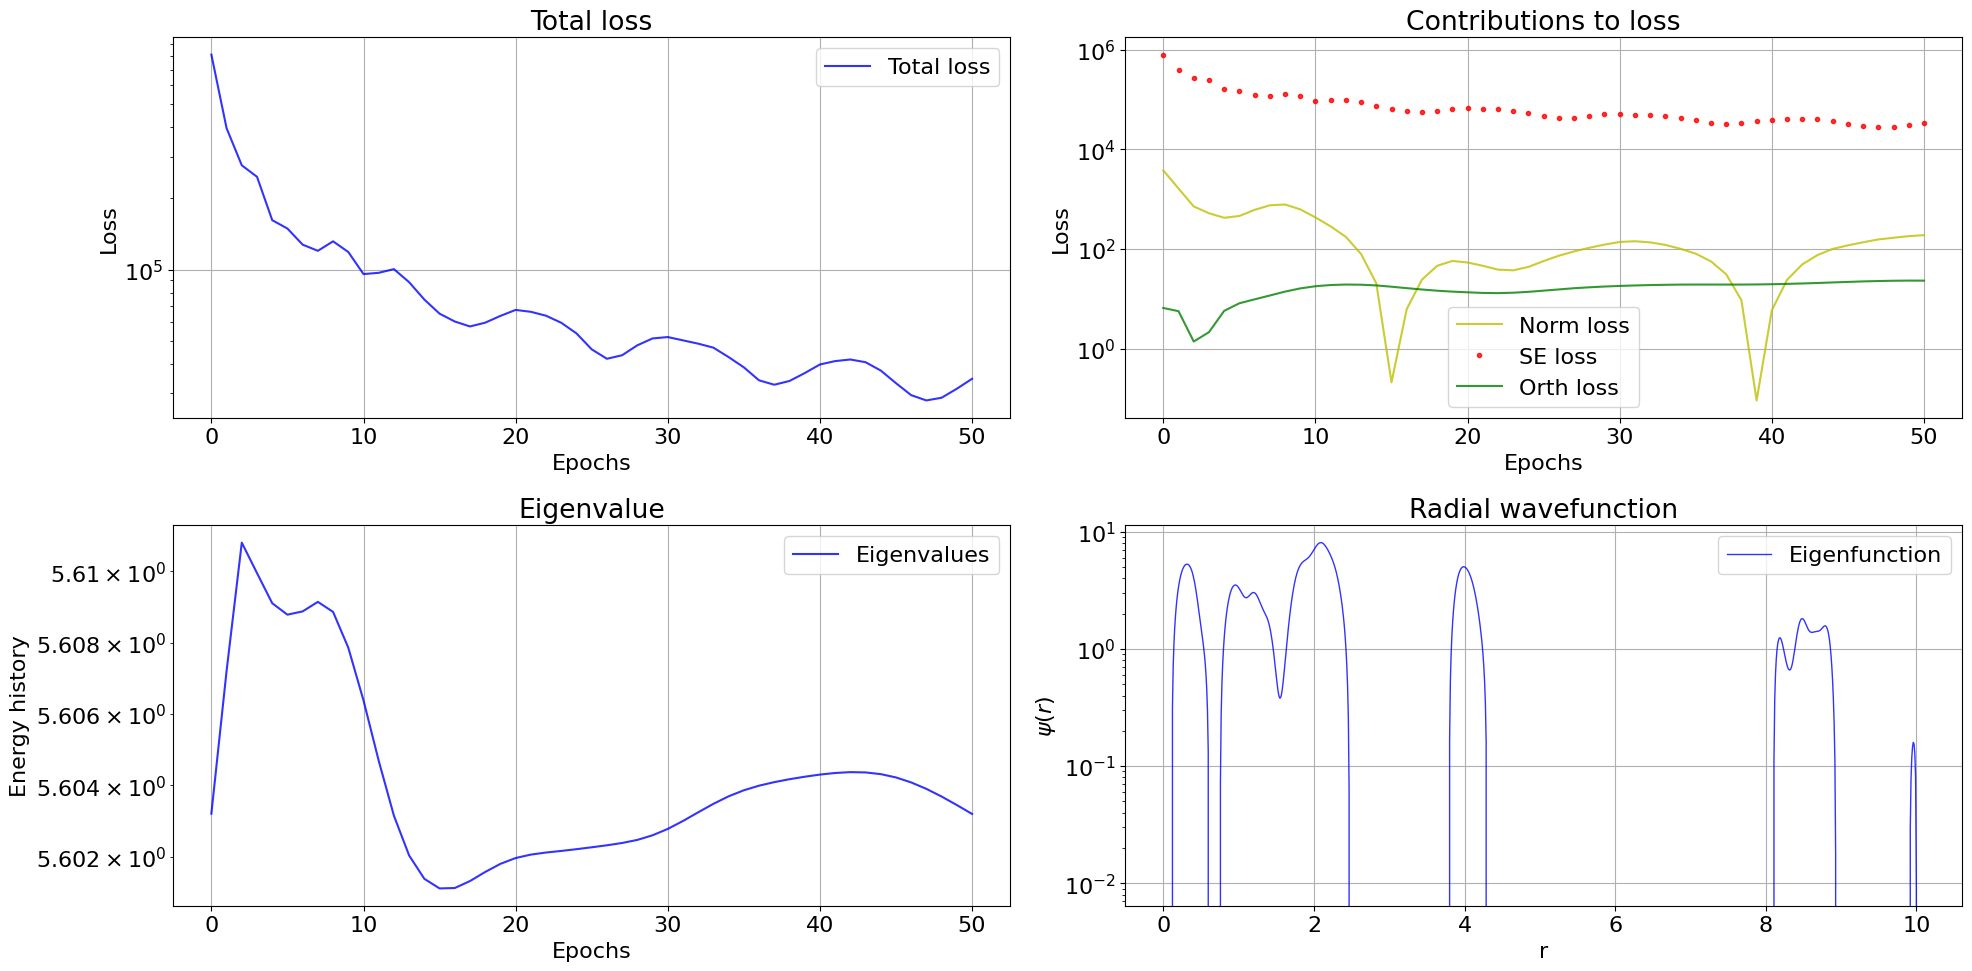

In [95]:
plots(t0,tf,n_train,model_s,loss_history_s)

tensor([5.6037], grad_fn=<Unique2Backward0>)


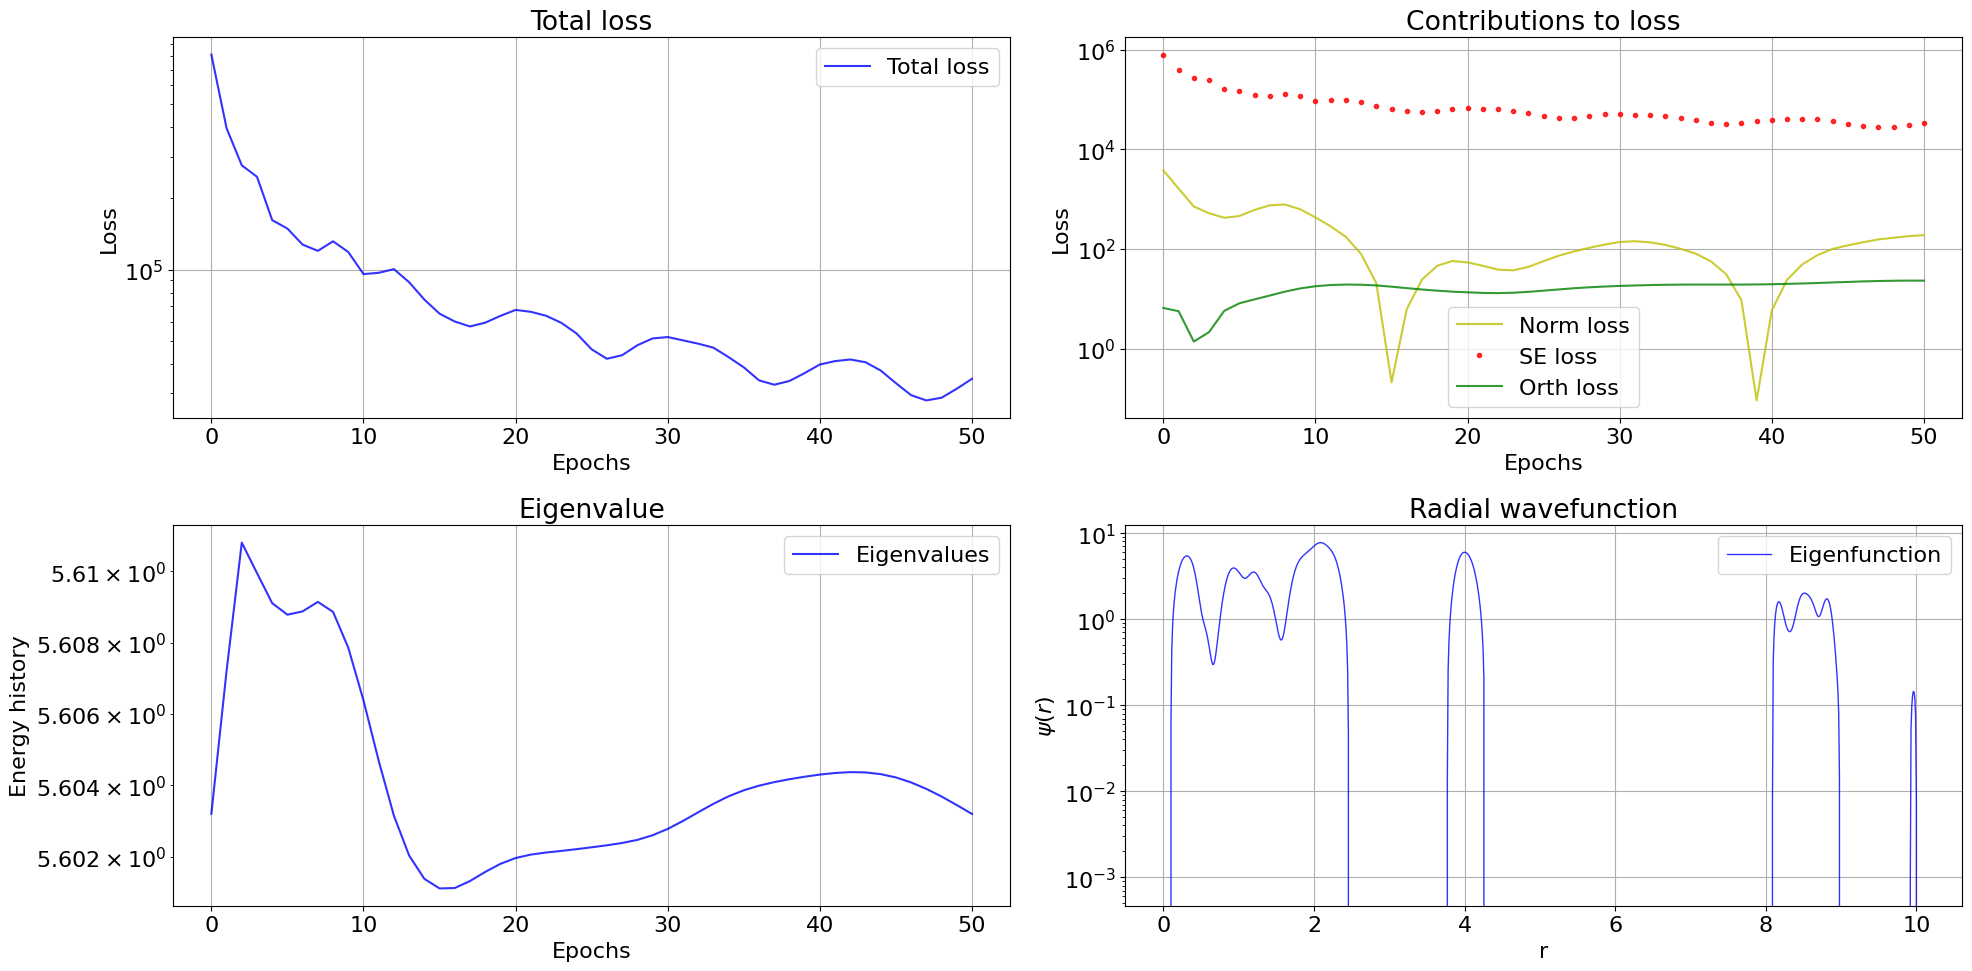

In [96]:
plots(t0,tf,n_train,best_model_s,loss_history_s)